In [45]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yaml
from sklearn.metrics import r2_score
import TriCorreX.utils.scaling as scaling
from TriCorreX.correlations import g2
from TriCorreX.utils.sample import sample_points 
from TriCorreX.entropy.s2 import compute_s2_cumulative

In [341]:
g2_gas = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/gas/g2_1.npy')
g2_liquid = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/liquid/g2_1.npy')

msd_gas = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/gas/msd_1.npy')
msd_liquid = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/liquid/msd_1.npy')
D_gas = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/gas/D_1.npy')
D_liquid = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/liquid/D_1.npy')

rho_gas, rho_liquid = 0.5, 0.85
T_gas, T_liquid = 1.2, 1.0

In [342]:
gas_dist, gas_rdf = g2_gas[:, 0], g2_gas[:, 1]
liquid_dist, liquid_rdf = g2_liquid[:, 0], g2_liquid[:, 1]

df_gas = pd.DataFrame({'r': gas_dist, 'g2': gas_rdf})
df_liquid = pd.DataFrame({'r': liquid_dist, 'g2': liquid_rdf})

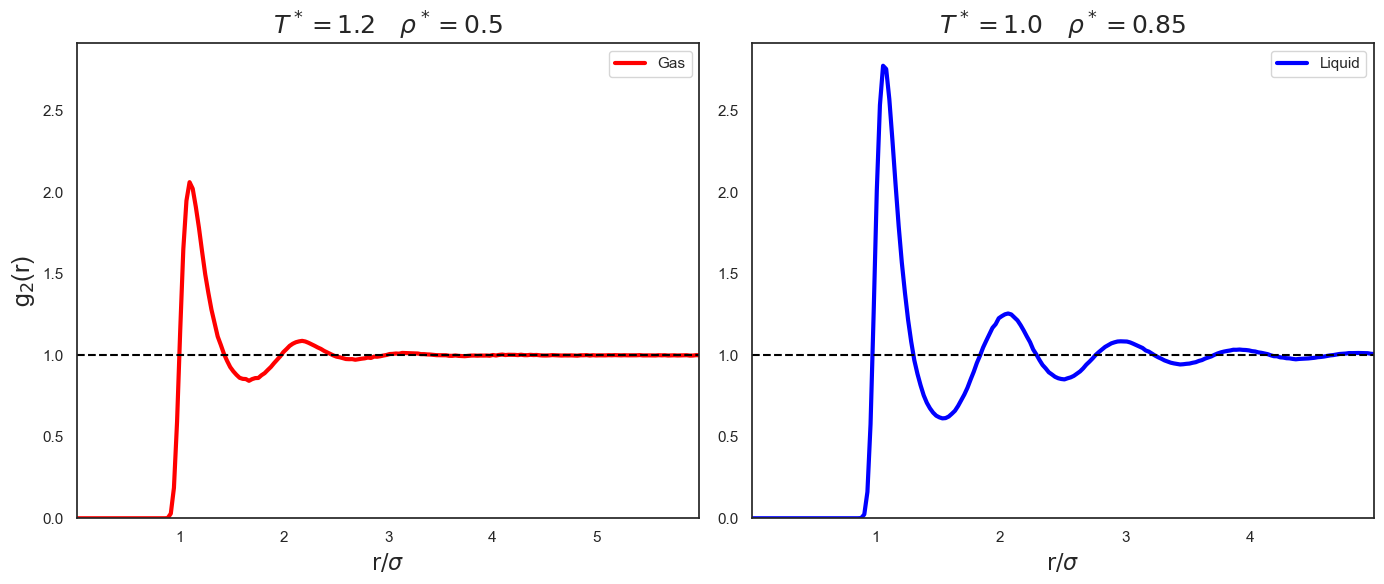

In [346]:
# Assuming df_gas and df_liquid are dataframes containing your data
minY = min(df_gas['g2'].min(), df_liquid['g2'].min())
maxY = max(df_gas['g2'].max(), df_liquid['g2'].max())

# Set Seaborn style
sns.set_theme(style="white")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Plot the gas RDF
sns.lineplot(x=gas_dist, y=gas_rdf, ax=axes[0], label='Gas', color='red', linewidth=3)
axes[0].plot(gas_dist, np.ones(len(gas_dist)), '--', color='black')  # Reference line at g2=1
axes[0].set_xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
axes[0].set_ylabel(r'g$_2$(r)', fontsize=18)
axes[0].set_xlim(gas_dist[0], gas_dist[-1])
axes[0].set_ylim(minY, maxY * 1.05)
axes[0].set_title(r'$T^*={T_gas} \ \ \ \rho ^*={rho_gas} $'.format(T_gas=T_gas, rho_gas=rho_gas), fontsize=18)

# Plot the liquid RDF
sns.lineplot(x=liquid_dist, y=liquid_rdf, ax=axes[1], label='Liquid', linewidth=3, color='blue')
axes[1].plot(liquid_dist, np.ones(len(liquid_dist)), '--', color='black')  # Reference line at g2=1
axes[1].set_xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
axes[1].set_xlim(liquid_dist[0], liquid_dist[-1])
axes[1].set_ylim(minY, maxY * 1.05)
axes[1].set_title(r'$T^*={T_liquid} \ \ \ \rho ^*={rho_liquid} $'.format(T_liquid=T_liquid, rho_liquid=rho_liquid), fontsize=18)

# Adjust layout
plt.tight_layout()
plt.show()

In [52]:
s2_gas = compute_s2_cumulative(gas_dist, gas_rdf, rho = rho_gas)
s2_liquid = compute_s2_cumulative(liquid_dist, liquid_rdf, rho = rho_liquid)

# We take the final value of the cumulative s2 as the 'ground truth' value
s2_gas_final = s2_gas[-1]
s2_liquid_final = s2_liquid[-1]

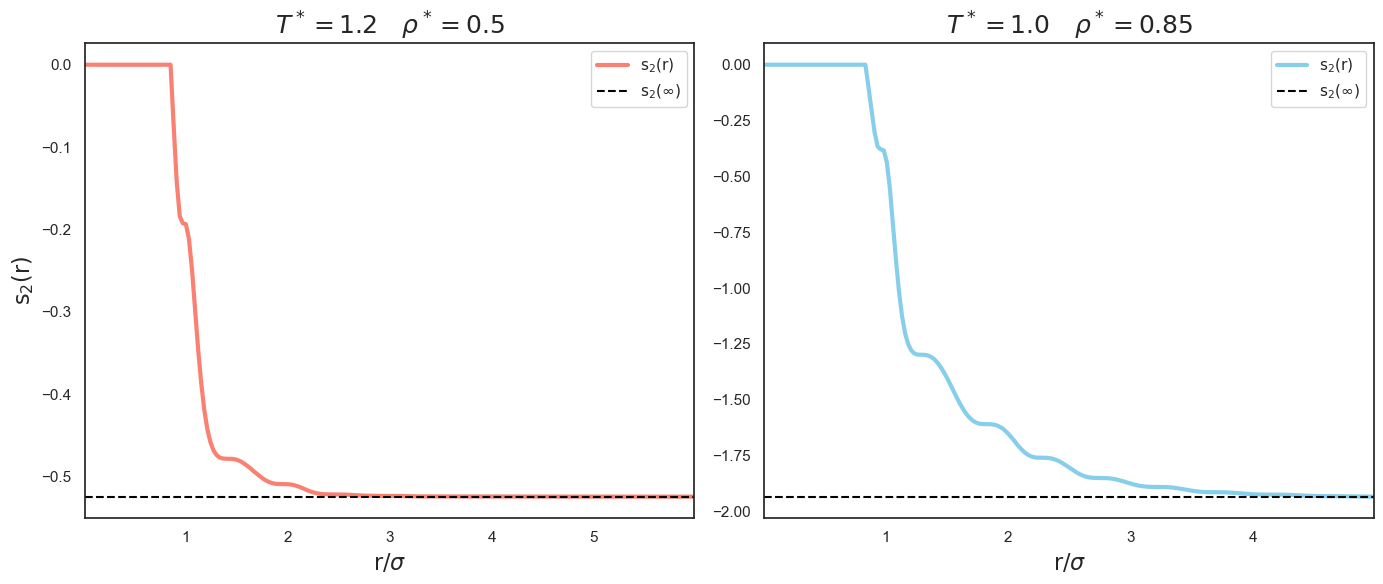

In [347]:
sns.set_theme(style="white")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the gas s2
sns.lineplot(x=gas_dist, y=s2_gas, ax=axes[0], label=r'$\mathsf{s}_2(\mathsf{r})$', color='salmon', linewidth=3)
axes[0].plot(gas_dist, np.ones_like(gas_dist) * s2_gas_final, '--', color='black', label=r'$\mathsf{s}_2(\infty)$')  # Reference line
axes[0].set_xlim(gas_dist[0], gas_dist[-1])
axes[0].set_xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
axes[0].set_ylabel(r'$\mathsf{s}_2(\mathsf{r})$', fontsize=16)
axes[0].set_title(r'$T^*= {T_gas} \ \ \ \rho ^*={rho_gas} $'.format(T_gas=T_gas, rho_gas=rho_gas), fontsize=18)
axes[0].legend()

# Plot the liquid s2
sns.lineplot(x=liquid_dist, y=s2_liquid, ax=axes[1], label=r'$\mathsf{s}_2(\mathsf{r})$', color='skyblue', linewidth=3)
axes[1].plot(liquid_dist, np.ones_like(liquid_dist) * s2_liquid_final, '--', color='black', label=r'$\mathsf{s}_2(\infty)$')  # Reference line
axes[1].set_xlim(liquid_dist[0], liquid_dist[-1])
axes[1].set_xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
axes[1].set_title(r'$T^*= {T_liquid} \ \ \ \rho ^*={rho_liquid} $'.format(T_liquid=T_liquid, rho_liquid=rho_liquid), fontsize=18)
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [55]:
s2_gas_conv = s2_gas/s2_gas_final
s2_liquid_conv = s2_liquid/s2_liquid_final

# Find the point where it is .99 percent converged 
gas_conv_idx = np.argmax(s2_gas_conv >= 0.99)
liquid_conv_idx = np.argmax(s2_liquid_conv >= 0.99)

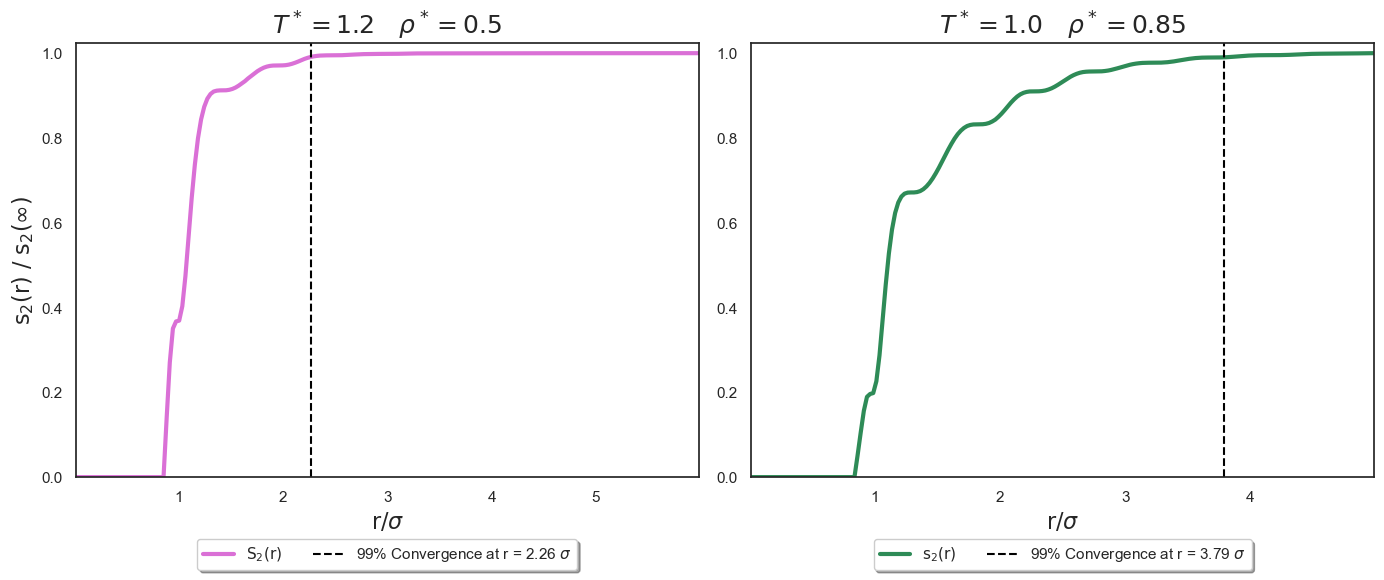

In [348]:
sns.set_theme(style="white")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for gas data
sns.lineplot(x=gas_dist, y=s2_gas_conv, ax=axes[0], label=r'$\mathsf{S}_2(\mathsf{r})$', color='orchid', linewidth=3)
axes[0].axvline(x=gas_dist[gas_conv_idx], color='black', linestyle='--', 
                label='99% Convergence at r = {:.2f} $\sigma$'.format(gas_dist[gas_conv_idx]))  # Vertical line
axes[0].set_xlim(gas_dist[0], gas_dist[-1])
axes[0].set_ylim(0, 1.025)
axes[0].set_xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
axes[0].set_ylabel(r'$\mathsf{s}_2(\mathsf{r}) \ / \ \mathsf{s}_2(\infty)$', fontsize=16)
axes[0].set_title(r'$T^*={T_gas} \ \ \ \rho ^*={rho_gas} $'.format(T_gas=T_gas, rho_gas=rho_gas), fontsize=18)
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), shadow=True, ncol=2)

# Plot for liquid data
sns.lineplot(x=liquid_dist, y=s2_liquid_conv, ax=axes[1], label=r'$\mathsf{s}_2(\mathsf{r})$', color='seagreen', linewidth=3)
axes[1].axvline(x=liquid_dist[liquid_conv_idx], color='black', linestyle='--', 
                label='99% Convergence at r = {:.2f} $\sigma$'.format(liquid_dist[liquid_conv_idx]))  # Vertical line
axes[1].set_xlim(liquid_dist[0], liquid_dist[-1])
axes[1].set_ylim(0, 1.025)
axes[1].set_xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
axes[1].set_title(r'$T^*={T_liquid} \ \ \ \rho ^*={rho_liquid} $'.format(T_liquid=T_liquid, rho_liquid=rho_liquid), fontsize=18)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), shadow=True, ncol=2)

# Adjust layout
plt.tight_layout()
plt.show()




In [349]:
# Fit expontial model of D_rs vs. S2 
x = np.array([s2_gas_final, s2_liquid_final])
D_gas_rs, D_liquid_rs = scaling.scale_D(D_gas, rho_gas, T_gas), scaling.scale_D(D_liquid, rho_liquid, T_liquid)
y_log = np.log([D_gas_rs, D_liquid_rs])
slope, intercept = np.polyfit(x, y_log, 1)
a1 = np.exp(intercept)
a2 = slope
y_fit = a1 * np.exp(a2 * x)

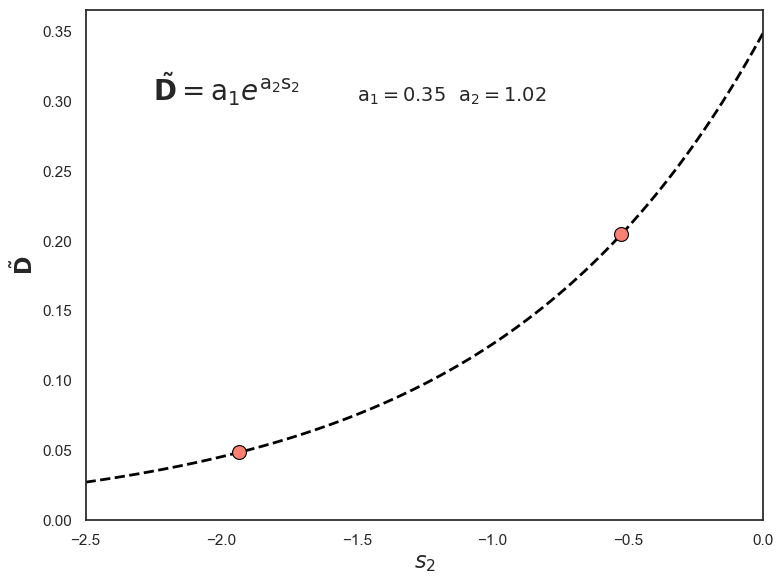

In [353]:
sns.set_style(style="white")

# Define x_range
x_range = np.linspace(-2.5, 0, 100)

# Create the figure
plt.figure(figsize=(8, 6))

# Plot the exponential curve
sns.lineplot(x=x_range, y=a1 * np.exp(a2 * x_range), color='black', linewidth=2, linestyle='--')

# Plot the points for D_gas_rs and D_liquid_rs
sns.scatterplot(x=x, y=[D_gas_rs, D_liquid_rs], color='salmon', edgecolor='black', s=100, alpha=1, zorder=3)

# Adding the text annotations
plt.text(-2.25, 0.3, r'$\tilde{\mathbf{D}} = \mathsf{a}_{1} e^{ \mathsf{a}_{2} \mathsf{s}_2}$', fontsize=20)
plt.text(-1.5, 0.3, rf'$\mathsf{{a}}_{{1}} = {a1:.2f} \ \ \mathsf{{a}}_{{2}} = {a2:.2f}$', fontsize=14)

# Set labels and limits
plt.xlabel(r'$s_2$', fontsize=16)
plt.ylabel(r'$\tilde{\mathbf{D}}$', fontsize=16)
plt.xlim(-2.5, 0)
plt.ylim(0, None)

# Display the plot
plt.tight_layout()
plt.show()

In [354]:
g2_random = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/random/g2_1.npy')
random_dist, random_rdf = g2_random[:, 0], g2_random[:, 1]
rho_random = 1
T_random = 2.0
s2_random = compute_s2_cumulative(random_dist, random_rdf, rho = rho_random)
s2_random_final = s2_random[-1]
s2_random_ratio = s2_random/s2_random_final
s2_random_conv_idx = np.argmax(s2_random_ratio >= 0.99)



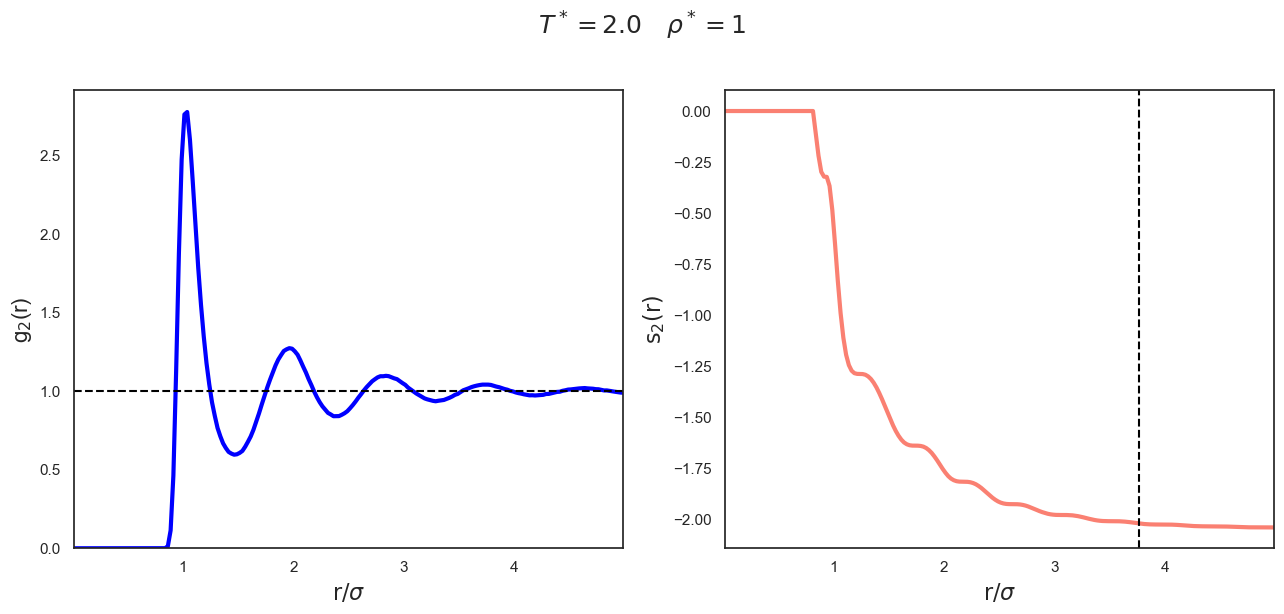

In [359]:
# Set Seaborn style
sns.set_theme(style="white")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Plot the random RDF on the first subplot
sns.lineplot(x=random_dist, y=random_rdf, ax=axes[0], linewidth=3, color='blue')
axes[0].plot(random_dist, np.ones(len(random_dist)), '--', color='black')  # Reference line at g2=1
axes[0].set_xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
axes[0].set_ylabel(r'g$_2$(r)', fontsize=16)
axes[0].set_xlim(random_dist[0], random_dist[-1])
axes[0].set_ylim(0, None)

# Plot the s2_random on the second subplot
sns.lineplot(x=random_dist, y=s2_random, ax=axes[1], color='salmon', linewidth=3)
axes[1].axvline(x=random_dist[s2_random_conv_idx], color='black', linestyle='--', 
                label='99% Convergence at r = {:.2f} $\sigma$'.format(random_dist[s2_random_conv_idx]))  # Vertical line
axes[1].set_xlim(random_dist[0], random_dist[-1])
axes[1].set_xlabel(r'$\mathsf{r} / \sigma$', fontsize=16)
axes[1].set_ylabel(r'$\mathsf{s}_2(\mathsf{r})$', fontsize=16)

# Adding a title in the middle
fig.suptitle(r'$T^*={T_random} \ \ \ \rho ^*={rho_random} $'.format(T_random=T_random, rho_random=rho_random), fontsize=18, y=1.02)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [92]:
def predict_D(s2, a1, a2, rho=None, T=None, scale=False):
    D = a1 * np.exp(a2 * s2)
    if scale:
        return D
    else:
        return scaling.unscale_D(D, rho, T)

In [93]:
D_random = np.load('/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/random/D_1.npy')
s2_random_approx = s2_random[s2_random_conv_idx]
D_random_pred = predict_D(s2_random_approx, slope, intercept, rho=1, T=2)
D_random_rs = scaling.scale_D(D_random, 1, 2)
D_random_rs_pred = scaling.scale_D(D_random_pred, 1, 2)

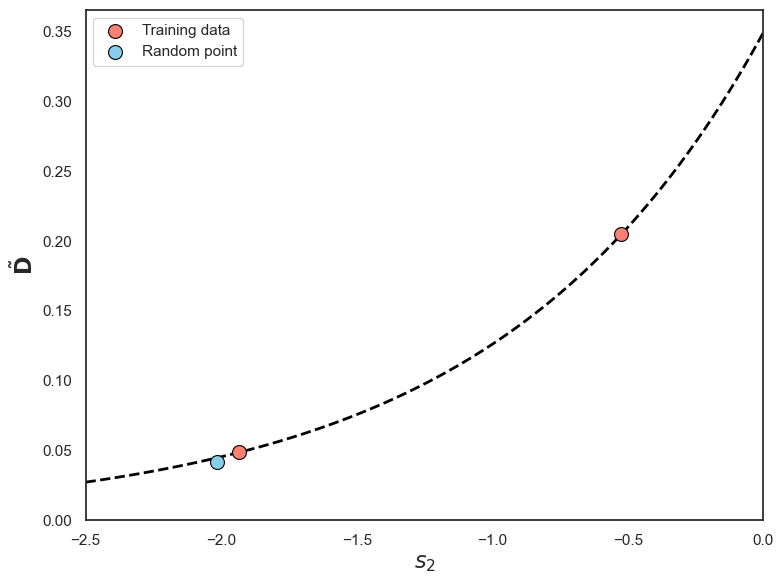

In [367]:
sns.set_theme(style="white")

# Define x_range
x_range = np.linspace(-2.5, 0, 100)

# Create the figure
plt.figure(figsize=(8, 6))

# Plot the exponential curve using Seaborn
sns.lineplot(x=x_range, y=a1 * np.exp(a2 * x_range), color='black', linewidth=2, linestyle='--')

# Plot the points for D_gas_rs and D_liquid_rs
sns.scatterplot(x=x, y=[D_gas_rs, D_liquid_rs], color='salmon', edgecolor='black', s=100, alpha=1, label='Training data', zorder=3)

# Plot the points for D_random_rs
sns.scatterplot(x=[s2_random_approx], y=[D_random_rs], color='skyblue', edgecolor='black', s=100, alpha=1, label='Random point', zorder=3)


# Set labels and limits
plt.xlabel(r'$s_2$', fontsize=16)
plt.ylabel(r'$\tilde{\mathbf{D}}$', fontsize=16)
plt.xlim(-2.5, 0)
plt.ylim(0, None)

# Display the plot
plt.tight_layout()
plt.show()

In [21]:
def numpy_representer(dumper, data):
    if isinstance(data, np.float64):
        return dumper.represent_float(float(data))  # Cast np.float64 to float
    elif isinstance(data, np.int64):
        return dumper.represent_int(int(data))  # Cast np.int64 to int
    elif isinstance(data, np.str_):
        return dumper.represent_str(str(data))  # Cast np.str_ to string

# Add custom representers to handle NumPy types
yaml.add_representer(np.float64, numpy_representer)
yaml.add_representer(np.int64, numpy_representer)
yaml.add_representer(np.str_, numpy_representer)


def make_sample_points(state_points, trials=1, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1e6)
    rng = np.random.default_rng(seed)
    seeds = rng.integers(0, 1e4, size=(len(state_points), trials, 2))
    settings = yaml.load(open(('lennard_jones/lj.yaml'), 'r'), Loader=yaml.FullLoader)
    params = yaml.load(open(('lennard_jones/params.yaml'), 'r'), Loader=yaml.FullLoader)
    num_atoms = settings['system_settings']['num_atoms']
    for idx, state in enumerate(state_points):
        os.makedirs('lennard_jones/samples/sample_{}'.format(idx+1), exist_ok=True)
        rho, T = state[0]
        region = state[1]
        length = np.round((num_atoms/rho)**(1/3), 3)
        settings['system_settings']['length'] = length
        settings['thermo_settings']['temp'] = T

        # Maximum distance to measure for g2(r) is floor(L/2)
        # We want enough bins such that delr ~ 0.05
        r_max = np.floor(length/2)
        n_bins = np.ceil(r_max/0.05)
        params['L'] = length
        params['rho'] = rho
        params['g2']['n_bins'] = int(n_bins)
        params['g2']['r_max'] = r_max

        labels = ['id', 'rho', 'T', 'LJ-region']
        values = [idx+1, rho, T, region]

        for trial in range(trials):
            pos_seed, vel_seed = seeds[idx, trial]
            settings['system_settings']['pos_seed'] = pos_seed
            settings['run_settings']['vel_seed'] = vel_seed
            # Write yaml file to new directory
            with open('lennard_jones/samples/sample_{}/input_{}.yaml'.format(idx+1, trial+1), 'w') as f:
                yaml.dump(settings, f, default_flow_style=False, sort_keys=False)

        with open('lennard_jones/samples/sample_{}/params.yaml'.format(idx+1), 'w') as f:
            yaml.dump(params, f, default_flow_style=False, sort_keys=False)

        with open('lennard_jones/samples/sample_{}/settings.yaml'.format(idx+1), 'w') as f:
            yaml.dump(dict(zip(labels, values)), f)
        


In [263]:
# Now let's sample 64 more points for a total dataset of 67 points 
trials = 10
samples = 64
seed = 42 # Seed for reproducibility
state_points = sample_points(N=samples, seed=seed)
make_sample_points(state_points, seed=314, trials=trials)

In [267]:
# Now we analyze the samples
paths = ['/Users/nickhattrup/Documents/research/projects/TriCorreX/examples/lennard_jones/samples/sample_{}/'.format(i+1) for i in range(samples)]
rho_lst = [yaml.load(open(path + 'settings.yaml', 'r'), Loader=yaml.FullLoader)['rho'] for path in paths]
T_lst = [yaml.load(open(path + 'settings.yaml', 'r'), Loader=yaml.FullLoader)['T'] for path in paths]
reg_lst = [yaml.load(open(path + 'settings.yaml', 'r'), Loader=yaml.FullLoader)['LJ-region'] for path in paths]


s2 = []
D = []
D_scaled = []
 
for idx, path in enumerate(paths):
    dist = np.load(path + 'g2_1.npy')[:, 0]
    rdfs = [np.load(path + 'g2_{}.npy'.format(i+1))[:, 1] for i in range(trials)]
    rdf_avg = np.mean(rdfs, axis=0)
    s2_avg = compute_s2_cumulative(dist, rdf_avg, rho_lst[idx])[-1]
    s2.append(s2_avg)
    diffusivities = [np.load(path + 'D_{}.npy'.format(i+1)) for i in range(trials)]
    d_avg = np.mean(diffusivities, axis=0)
    d_avg_scale = scaling.scale_D(d_avg, rho_lst[idx], T_lst[idx])
    D.append(d_avg)
    D_scaled.append(d_avg_scale)
    
log_D_scaled = np.log(D_scaled)    


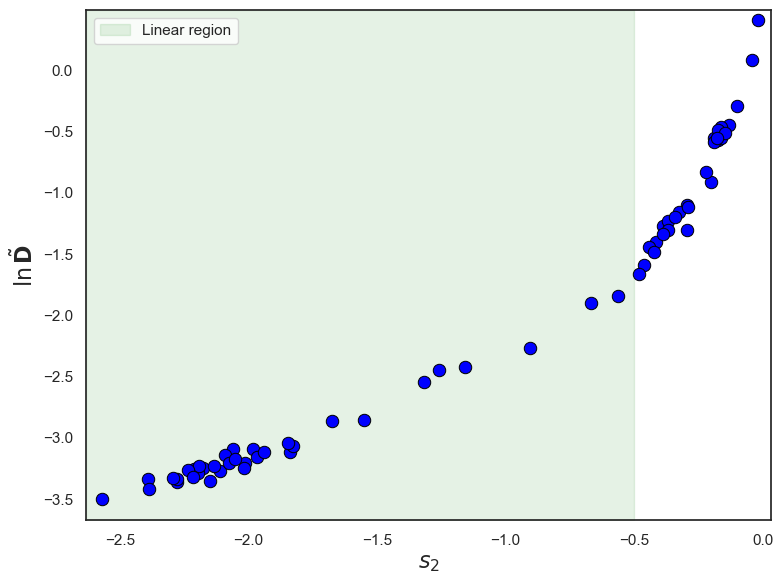

In [379]:
# Set Seaborn style
sns.set_theme(style="white")

# Create the figure
plt.figure(figsize=(8, 6))

# Shade the area up to s2 = -0.5
plt.fill_betweenx(y=[np.min(log_D_scaled) * 1.05, np.max(log_D_scaled) * 1.2], 
                  x1=np.min(s2) * 1.025, x2=-0.5, color='green', alpha=0.1, label='Linear region')

# Scatter plot for s2 vs. log_D_scaled
sns.scatterplot(x=s2, y=log_D_scaled, edgecolor='black', color='blue', s=80)

# Set the limits, labels, and title
plt.xlim(np.min(s2) * 1.025, np.max(s2) + 0.05)
plt.ylim(np.min(log_D_scaled) * 1.05, np.max(log_D_scaled) * 1.2)
plt.xlabel(r'$s_2$', fontsize=16)
plt.ylabel(r'$\ln{\tilde{\mathbf{D}}}$', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()


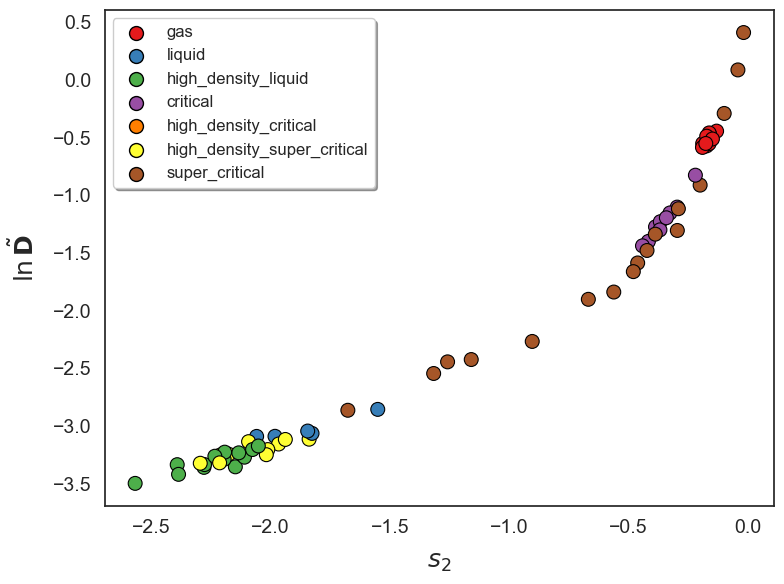

In [380]:
# Recreate same plot as above, but color each point by region

reg_colors = {'gas': 'red', 'liquid': 'blue', 'high_density_liquid': 'green', 'critical': 'purple', 'high_density_critical': 'orange', 'high_density_super_critical': 'black', 'super_critical': 'yellow'}

sns.set_theme(style="white")

# Use a more visually appealing color palette
palette = sns.color_palette('Set1', n_colors=len(reg_colors))  # 'Set1' has vibrant and distinct colors
reg_color_mapping = dict(zip(reg_colors.keys(), palette))

# Create the figure
plt.figure(figsize=(8, 6))

# Plot the scatter plot with improved color palette
sns.scatterplot(x=s2, y=log_D_scaled, hue=reg_lst, palette=reg_color_mapping, edgecolor='black', s=100, legend=False)

# Manually add a legend with improved styling
for reg, color in reg_color_mapping.items():
    plt.scatter([], [], color=color, label=reg, s=100, edgecolor='black')

# Adjust the legend properties
plt.legend(loc='upper left', fontsize=12, title_fontsize=14, frameon=True, fancybox=True, shadow=True)

# Set axis labels with improved font sizes
plt.xlabel(r'$s_2$', fontsize=18, labelpad=10)
plt.ylabel(r'$\ln{\tilde{\mathbf{D}}}$', fontsize=18, labelpad=10)

# Adjust tick label sizes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Display the plot with tight layout
plt.tight_layout()
plt.show()

In [387]:
# Compare our samples with prediction 
linear_region = np.where(np.array(s2) < -0.5)
s2_linear = np.array(s2)[linear_region]
# Add liquid, gas and random points to the array
s2_linear = np.append(s2_linear, [s2_gas_final, s2_liquid_final, s2_random_final])
rho_linear = np.array(rho_lst)[linear_region]
rho_linear = np.append(rho_linear, [rho_gas, rho_liquid, 1])
T_linear = np.array(T_lst)[linear_region]
T_linear = np.append(T_linear, [T_gas, T_liquid, 1])
D_linear = np.array(D)[linear_region]
D_linear = np.append(D_linear, [D_gas, D_liquid, D_random])
D_linear_scaled = np.array(D_scaled)[linear_region]
D_linear_scaled = np.append(D_linear_scaled, [D_gas_rs, D_liquid_rs, D_random_rs])
D_linear_log_scaled = np.log(D_linear_scaled)


In [392]:
# Given these 38 points, we can now fit a linear model to predict D_rs
# We randomly sample 8 points for training and 30 for testing 

points = np.arange(2, len(s2_linear)//2)

trials = 10000
errors_per_point = []
top_error_per_point = []
for point in points:
    errors = []
    top_errors = []
    for _ in range(trials):
        train_idx = np.random.choice(len(s2_linear), point, replace=False)
        test_idx = np.array([i for i in range(len(s2_linear)) if i not in train_idx])

        s2_train = s2_linear[train_idx]
        rho_train = rho_linear[train_idx]
        T_train = T_linear[train_idx]
        D_linear_log_scaled_train = D_linear_log_scaled[train_idx]

        s2_test = s2_linear[test_idx]
        rho_test = rho_linear[test_idx]
        T_test = T_linear[test_idx]
        D_linear_log_scaled_test = D_linear_log_scaled[test_idx]

        # Fit the model
        slope, intercept = np.polyfit(s2_train, D_linear_log_scaled_train, 1)
        a1 = np.exp(intercept)
        a2 = slope
        D_predictions = [predict_D(s2, a1, a2, rho=rho, T=T) for s2, rho, T in zip(s2_test, rho_test, T_test)]
        D_true = D_linear[test_idx]

        
        residuals = D_predictions - D_true
        sigma = np.std(residuals, ddof=1)
        z = 1.96 
        lower = D_predictions - z*sigma
        upper = D_predictions + z*sigma
        coverge = coverage = np.mean((D_true >= lower) & (D_true <= upper)) # How many predictions fall within the 95% confidence interval
        errors.append(coverge)

        top_errors.append(np.percentile(100*np.abs(D_predictions - D_true)/D_true, 99))


    errors_per_point.append(100*np.mean(errors))
    top_error_per_point.append(np.mean(top_errors))




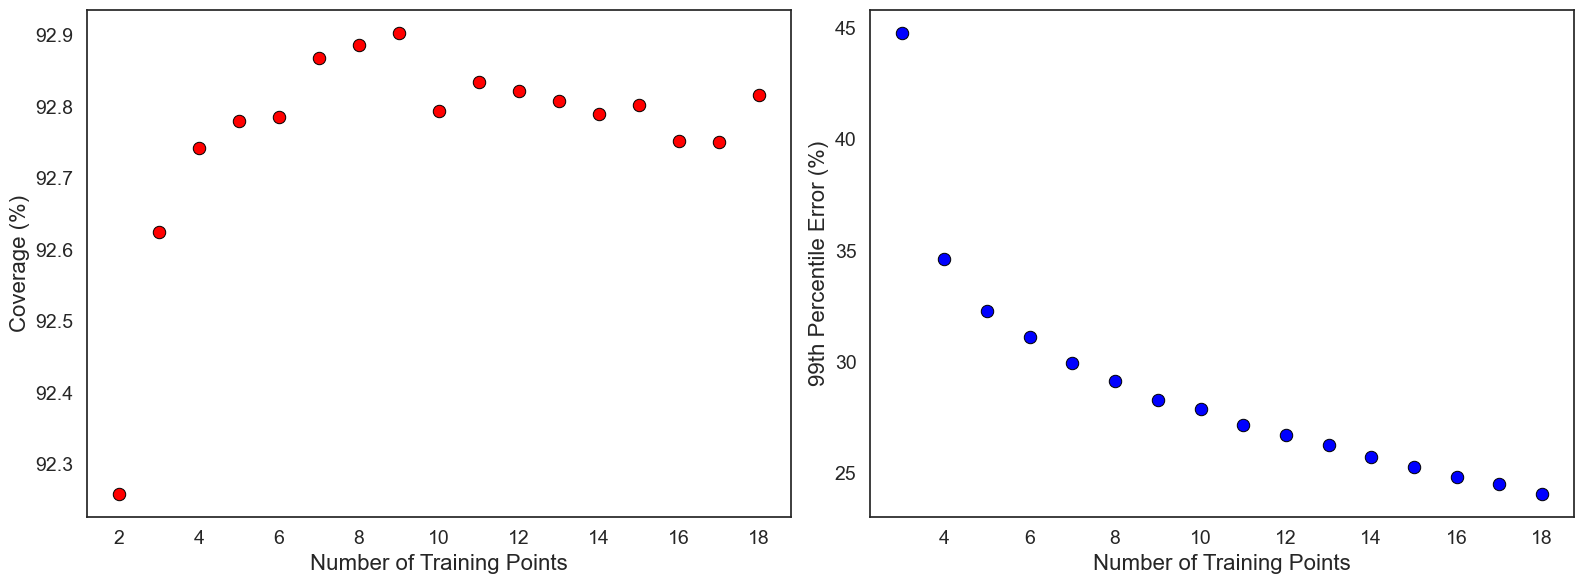

In [394]:
# Set Seaborn style
sns.set_theme(style="white")

# Create the figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first scatter plot using Seaborn's scatterplot function
sns.scatterplot(x=points, y=errors_per_point, ax=ax[0], color='red', edgecolor='black', s=80)
ax[0].set_xlabel('Number of Training Points', fontsize=16)
ax[0].set_ylabel('Coverage (%)', fontsize=16)
ax[0].tick_params(axis='both', labelsize=14)

# Plot the second scatter plot
sns.scatterplot(x=points[1:], y=top_error_per_point[1:], ax=ax[1], color='blue', edgecolor='black', s=80)
ax[1].set_xlabel('Number of Training Points', fontsize=16)
ax[1].set_ylabel('99th Percentile Error (%)', fontsize=16)
ax[1].tick_params(axis='both', labelsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# for idx, path in enumerate(paths):
#     dist = np.load(path + 'g2_1.npy')[:, 0]
#     rdfs = [np.load(path + 'g2_{}.npy'.format(i+1))[:, 1] for i in range(trials)]
#     s2s = [compute_s2_cumulative(dist, rdf, rho_lst[idx])[-1] for rdf in rdfs]
#     rdf_avg = np.mean(rdfs, axis=0)
#     rdf_std = np.std(rdfs, axis=0, ddof=1)
#     s2_avg = compute_s2_cumulative(dist, rdf_avg, rho_lst[idx])
#     diffusivities = [np.load(path + 'D_{}.npy'.format(i+1)) for i in range(trials)]
#     diffusivities_rs = [scaling.scale_D(D, rho_lst[idx], T_lst[idx]) for D in diffusivities]
#     D_avg = np.mean(diffusivities, axis=0)
#     D_std = np.std(diffusivities, axis=0, ddof=1)
#     # Sample rdf from mvt normal distribution
#     rdf_samples = np.random.multivariate_normal(mean=rdf_avg, cov=np.diag(rdf_std**2), size=100)
#     s2_samples = [compute_s2_cumulative(dist, rdf, rho_lst[idx]) for rdf in rdf_samples]
#     if idx == 2:
#         break